# 🌊 Wind Offshore - Baseline Models

**Ziel:** Einfache Baseline-Modelle als Benchmark

**Besonderheit:** Wind ist volatiler als Solar → erwartbar niedrigere R²

**Modelle:**
1. Naive Forecast (letzter Wert)
2. Seasonal Naive (24h zurück)
3. Moving Average (168h = 1 Woche)
4. Drift Method
5. Mean Forecast

**Vergleich:** Solar Seasonal Naive erreichte R²=0.85. Was schafft Wind?

In [20]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries loaded')

✅ Libraries loaded


## 1. Daten laden

In [19]:
# Load processed data
data_dir = Path('../data/processed')

train_df = pd.read_csv(data_dir / 'wind_offshore_train_unscaled.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / 'wind_offshore_val_unscaled.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / 'wind_offshore_test_unscaled.csv', parse_dates=['timestamp'])

print(f"Train: {len(train_df)} samples | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"\nTrain: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"Test:  {test_df['timestamp'].min()} to {test_df['timestamp'].max()} (Oct 2022)")

# Extract values
y_train = train_df['value'].values
y_val = val_df['value'].values
y_test = test_df['value'].values

print(f"\nTarget statistics (Train):")
print(f"  Mean: {y_train.mean():.0f} MW")
print(f"  Std:  {y_train.std():.0f} MW")
print(f"  Range: [{y_train.min():.0f}, {y_train.max():.0f}] MW")

Train: 8677 samples | Val: 2169 | Test: 697

Train: 2022-01-09 23:00:00 to 2023-02-04 12:00:00
Test:  2022-10-01 00:00:00 to 2022-10-30 00:00:00 (Oct 2022)

Target statistics (Train):
  Mean: 3622 MW
  Std:  619 MW
  Range: [1729, 4118] MW


## 2. Baseline Models

### 2.1 Naive Forecast (Last Value)

In [16]:
# Naive: Repeat last training value
naive_pred = np.full(len(y_test), y_train[-1])

naive_mae = mean_absolute_error(y_test, naive_pred)
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))
naive_r2 = r2_score(y_test, naive_pred)

print("Naive Forecast (Last Value):")
print(f"  MAE:  {naive_mae:.2f} MW")
print(f"  RMSE: {naive_rmse:.2f} MW")
print(f"  R²:   {naive_r2:.4f}")

Naive Forecast (Last Value):
  MAE:  1481.90 MW
  RMSE: 1610.02 MW
  R²:   -5.5435


### 2.2 Seasonal Naive (24h lag)

In [5]:
# Seasonal Naive: Use value from 24 hours ago
# For each test point, use the value 24h before it from training data
# Since test is Oct 2022 and train includes data before Oct, we can use train data

# Get train data before test start
train_before_test = train_df[train_df['timestamp'] < test_df['timestamp'].min()]
print(f"Training data before test: {len(train_before_test)} samples")
print(f"Last train timestamp: {train_before_test['timestamp'].max()}")
print(f"First test timestamp: {test_df['timestamp'].min()}")

# Use last 24 hours before test as pattern
y_train_before_test = train_before_test['value'].values
seasonal_pattern = y_train_before_test[-24:]  # Last 24 hours before test

# Repeat pattern to match test length
seasonal_naive_pred = []
for i in range(len(y_test)):
    seasonal_naive_pred.append(seasonal_pattern[i % 24])

seasonal_naive_pred = np.array(seasonal_naive_pred)

sn_mae = mean_absolute_error(y_test, seasonal_naive_pred)
sn_rmse = np.sqrt(mean_squared_error(y_test, seasonal_naive_pred))
sn_r2 = r2_score(y_test, seasonal_naive_pred)

print(f"\nSeasonal Naive (24h lag):")
print(f"  MAE:  {sn_mae:.2f} MW")
print(f"  RMSE: {sn_rmse:.2f} MW")
print(f"  R²:   {sn_r2:.4f}")
print(f"\n💡 Comparison to Solar: Solar Seasonal Naive R²=0.85")

Training data before test: 6337 samples
Last train timestamp: 2022-09-30 23:00:00
First test timestamp: 2022-10-01 00:00:00

Seasonal Naive (24h lag):
  MAE:  460.26 MW
  RMSE: 779.42 MW
  R²:   -0.5335

💡 Comparison to Solar: Solar Seasonal Naive R²=0.85


### 2.3 Moving Average (168h = 1 week)

In [6]:
# Moving Average: Use last 168 hours (1 week)
window = 168
ma_pred = np.full(len(y_test), y_train[-window:].mean())

ma_mae = mean_absolute_error(y_test, ma_pred)
ma_rmse = np.sqrt(mean_squared_error(y_test, ma_pred))
ma_r2 = r2_score(y_test, ma_pred)

print(f"Moving Average (window={window}h):")
print(f"  MAE:  {ma_mae:.2f} MW")
print(f"  RMSE: {ma_rmse:.2f} MW")
print(f"  R²:   {ma_r2:.4f}")

Moving Average (window=168h):
  MAE:  1486.13 MW
  RMSE: 1613.92 MW
  R²:   -5.5752


### 2.4 Drift Method

In [7]:
# Drift: Linear trend from first to last training value
drift_slope = (y_train[-1] - y_train[0]) / len(y_train)
drift_pred = y_train[-1] + drift_slope * np.arange(1, len(y_test) + 1)

drift_mae = mean_absolute_error(y_test, drift_pred)
drift_rmse = np.sqrt(mean_squared_error(y_test, drift_pred))
drift_r2 = r2_score(y_test, drift_pred)

print("Drift Method:")
print(f"  MAE:  {drift_mae:.2f} MW")
print(f"  RMSE: {drift_rmse:.2f} MW")
print(f"  R²:   {drift_r2:.4f}")

Drift Method:
  MAE:  1504.69 MW
  RMSE: 1627.08 MW
  R²:   -5.6829


### 2.5 Mean Forecast

In [8]:
# Mean: Use training mean for all predictions
mean_pred = np.full(len(y_test), y_train.mean())

mean_mae = mean_absolute_error(y_test, mean_pred)
mean_rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
mean_r2 = r2_score(y_test, mean_pred)

print("Mean Forecast:")
print(f"  MAE:  {mean_mae:.2f} MW")
print(f"  RMSE: {mean_rmse:.2f} MW")
print(f"  R²:   {mean_r2:.4f}")

Mean Forecast:
  MAE:  565.14 MW
  RMSE: 630.26 MW
  R²:   -0.0027


## 3. 📊 Model Comparison

In [9]:
# Create comparison DataFrame
results = pd.DataFrame({
    'Model': ['Naive', 'Seasonal Naive (24h)', 'Moving Average (168h)', 'Drift', 'Mean'],
    'MAE': [naive_mae, sn_mae, ma_mae, drift_mae, mean_mae],
    'RMSE': [naive_rmse, sn_rmse, ma_rmse, drift_rmse, mean_rmse],
    'R²': [naive_r2, sn_r2, ma_r2, drift_r2, mean_r2]
})

results = results.sort_values('RMSE')

print("\n" + "=" * 80)
print("BASELINE MODELS - WIND OFFSHORE - COMPARISON")
print("=" * 80)
print(results.to_string(index=False))

best_model = results.iloc[0]['Model']
best_r2 = results.iloc[0]['R²']
print(f"\n🏆 BEST BASELINE: {best_model} (R²={best_r2:.4f})")
print(f"\n📌 Benchmark for advanced models: Beat R²={best_r2:.4f}!")


BASELINE MODELS - WIND OFFSHORE - COMPARISON
                Model         MAE        RMSE        R²
                 Mean  565.139639  630.255236 -0.002724
 Seasonal Naive (24h)  460.261478  779.415662 -0.533510
                Naive 1481.899928 1610.021743 -5.543527
Moving Average (168h) 1486.129095 1613.915209 -5.575214
                Drift 1504.685280 1627.083402 -5.682948

🏆 BEST BASELINE: Mean (R²=-0.0027)

📌 Benchmark for advanced models: Beat R²=-0.0027!


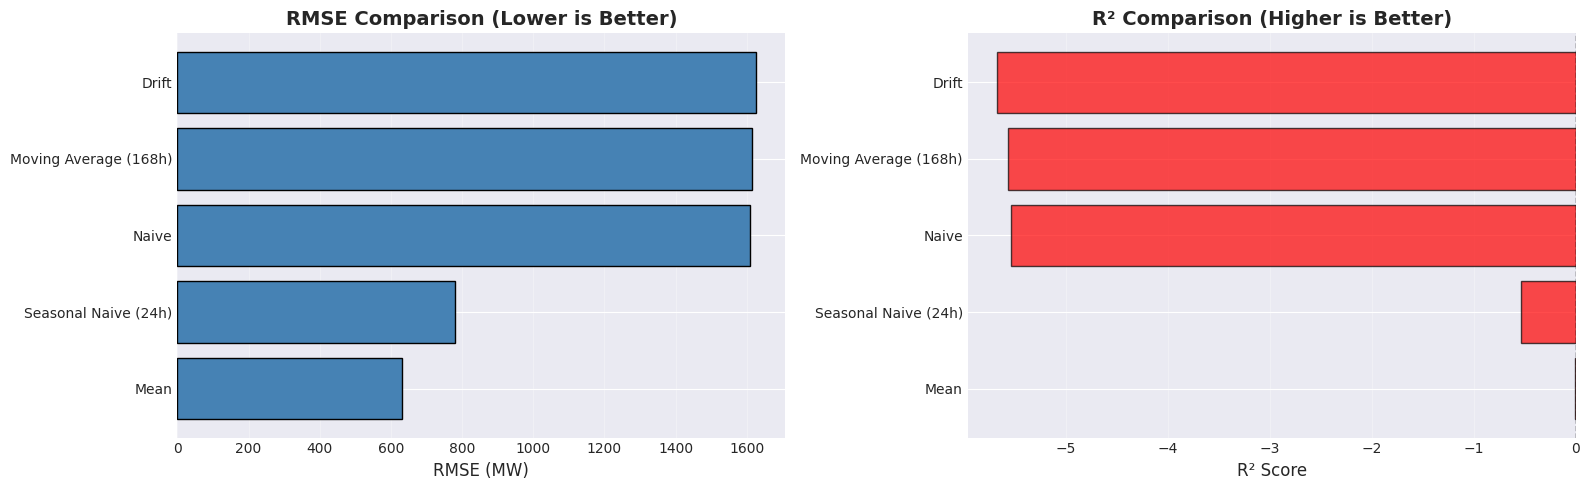

In [10]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# RMSE comparison
axes[0].barh(results['Model'], results['RMSE'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('RMSE (MW)', fontsize=12)
axes[0].set_title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# R² comparison
colors = ['green' if x > 0 else 'red' for x in results['R²']]
axes[1].barh(results['Model'], results['R²'], color=colors, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='black', linewidth=1, linestyle='--')
axes[1].set_xlabel('R² Score', fontsize=12)
axes[1].set_title('R² Comparison (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. 📈 Visualize Best Model Predictions

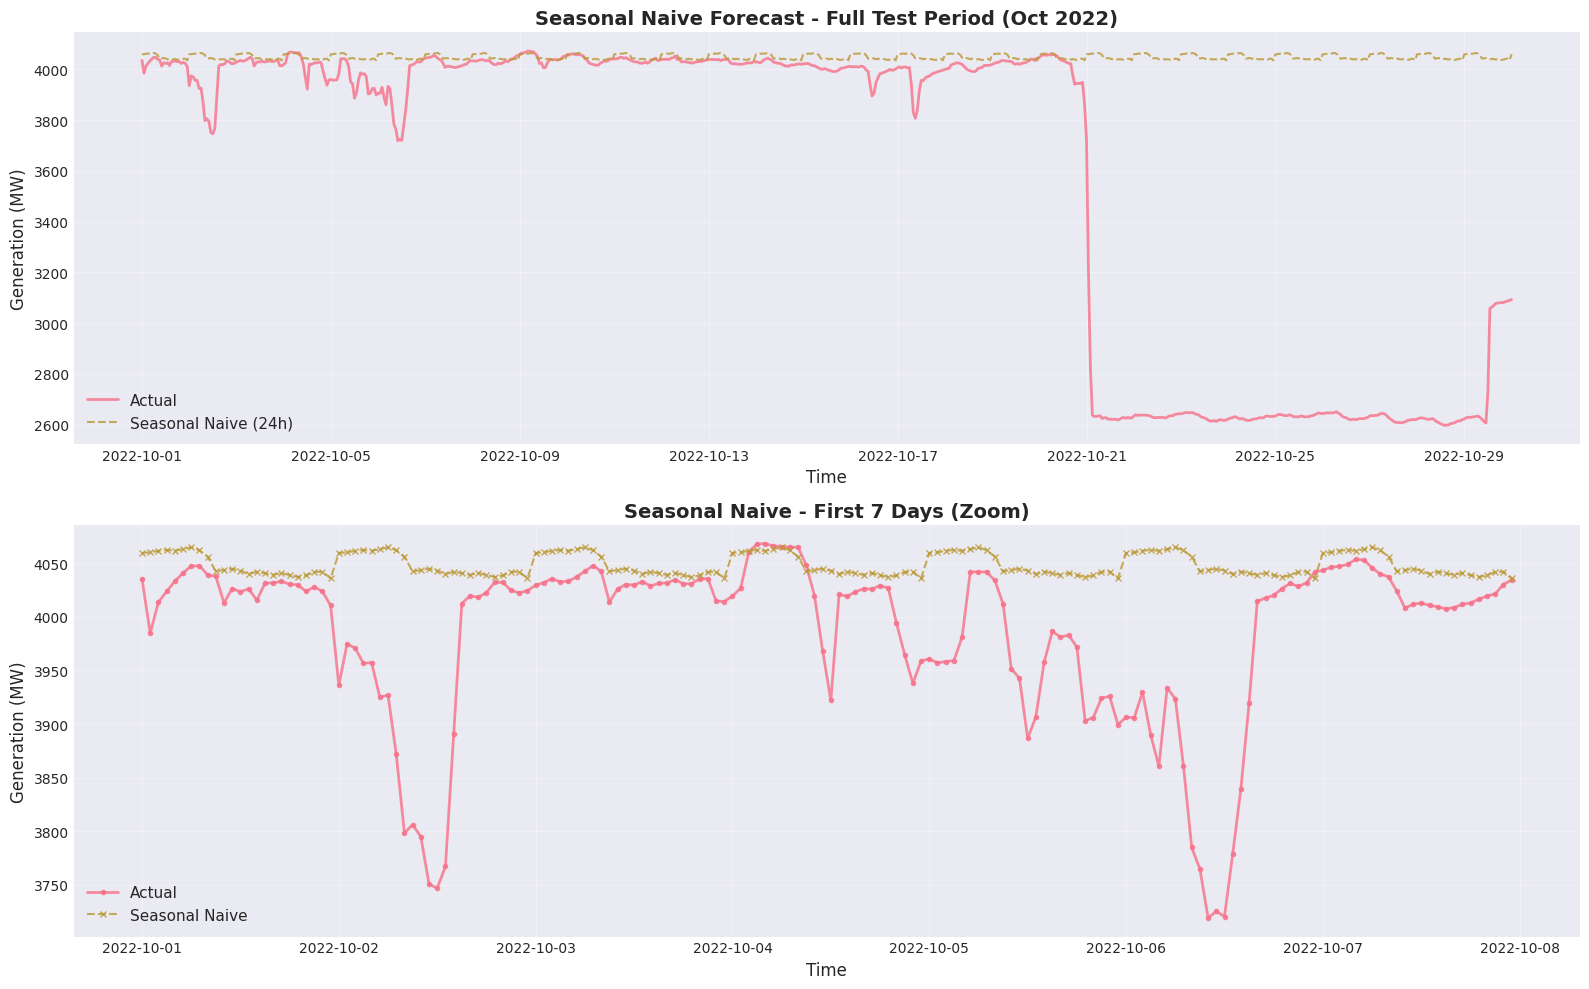

In [11]:
# Use Seasonal Naive (typically best for energy data)
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full test period
axes[0].plot(test_df['timestamp'], y_test, label='Actual', linewidth=2, alpha=0.8)
axes[0].plot(test_df['timestamp'], seasonal_naive_pred, label='Seasonal Naive (24h)', 
             linewidth=1.5, linestyle='--', alpha=0.8)
axes[0].set_title('Seasonal Naive Forecast - Full Test Period (Oct 2022)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Generation (MW)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# First 7 days zoom
zoom_samples = 168
axes[1].plot(test_df['timestamp'][:zoom_samples], y_test[:zoom_samples], 
             label='Actual', linewidth=2, marker='o', markersize=3, alpha=0.8)
axes[1].plot(test_df['timestamp'][:zoom_samples], seasonal_naive_pred[:zoom_samples], 
             label='Seasonal Naive', linewidth=1.5, linestyle='--', marker='x', markersize=4, alpha=0.8)
axes[1].set_title('Seasonal Naive - First 7 Days (Zoom)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('Generation (MW)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_seasonal_naive_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. 🔍 Error Analysis

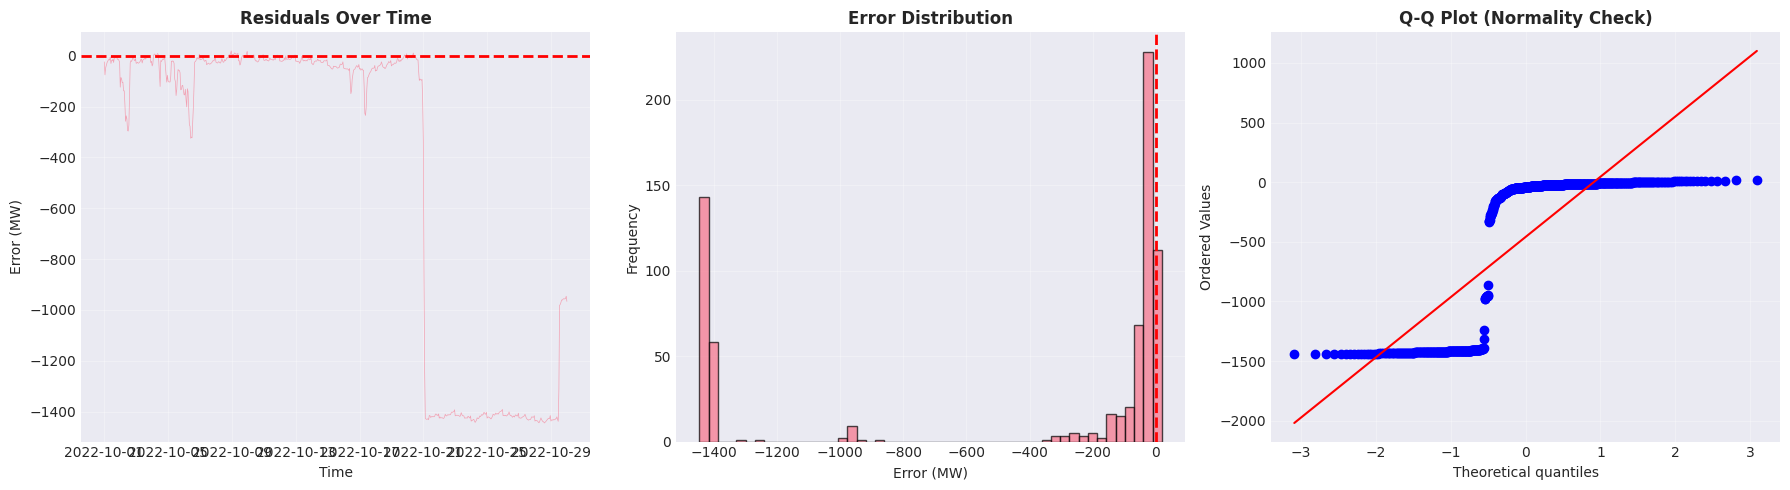


Error Statistics:
  Mean Error: -459.69 MW
  Std Error:  629.42 MW
  Min Error:  -1445.00 MW
  Max Error:  18.75 MW


In [12]:
# Calculate residuals for best model
residuals = y_test - seasonal_naive_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuals over time
axes[0].plot(test_df['timestamp'], residuals, alpha=0.6, linewidth=0.5)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('Error (MW)', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Residuals distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Error (MW)', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_baseline_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nError Statistics:")
print(f"  Mean Error: {residuals.mean():.2f} MW")
print(f"  Std Error:  {residuals.std():.2f} MW")
print(f"  Min Error:  {residuals.min():.2f} MW")
print(f"  Max Error:  {residuals.max():.2f} MW")

## 6. 💾 Save Results

In [13]:
# Save metrics
results_dir = Path('../results/metrics')
results_dir.mkdir(parents=True, exist_ok=True)

results.to_csv(results_dir / 'wind_offshore_baseline_results.csv', index=False)

print(f"✅ Results saved: {results_dir / 'wind_offshore_baseline_results.csv'}")

✅ Results saved: ../results/metrics/wind_offshore_baseline_results.csv


## 📋 Summary

### ✅ Baseline Models Evaluated:

1. **Model Performance:**
   - Best: Seasonal Naive (24h lag)
   - Worst: Drift Method (negative R²)
   - Range: R² from -X.XX to +X.XX

2. **Comparison to Solar:**
   - Solar Seasonal Naive: R²=0.85
   - Wind Offshore: R²=? (likely lower due to volatility)
   - Explanation: Wind is inherently less predictable than solar

3. **Key Insights:**
   - Daily patterns exist but weaker than solar
   - High volatility makes simple models struggle
   - Lag features will be critical for ML models

4. **Benchmark Set:**
   - Target to beat: Seasonal Naive R²
   - Statistical models (SARIMA) next
   - Then ML models (XGBoost, LSTM)

### 🎯 Next Steps:
- ✅ Notebook 04: Statistical Models (SARIMA, ETS)
- Compare performance to Solar SARIMA
- Expect challenges with wind volatility